# Position Encoding
In this exercise, we will look at position encoding for the Transformer architecture.

In [1]:
import torch
import torch.nn as nn

## Creating an Embedding
Consider the following vocabulary:

In [2]:
vocab = ['dog', 'cat', 'fox', 'walks', 'jumps', 'sleeps', 'and', 'the', '.', ',']
print(f'Vocab size: {len(vocab)}')

Vocab size: 10


Take a look at the [nn.Embedding documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). Create an embedding with a vocabulary size of 10 and an embedding dimension of 6.

In [3]:
embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=6)

Embed the sentence: "the dog sleeps , the cat walks and the fox jumps ."

In [4]:
sentence = "the dog sleeps , the cat walks and the fox jumps ."
tokens = sentence.split()
word_ids = [vocab.index(word) for word in tokens]
embeddings = embedding(torch.LongTensor(word_ids))

In [5]:
embeddings.shape

torch.Size([12, 6])

## Absolute Position Encoding
The functions for absolute position encoding, as defined in [the Transformer paper](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) are as follows:

$$
\begin{align}
pos_{i, 2j} &= \sin(i / 10000^{2j/d}) \\
pos_{i, 2j+1} &= \cos(i / 10000^{2j/d})
\end{align}
$$
where $i$ is the absolute position in the sequence, and $j$ is the dimension of the embedding vector.

Create a function `absolute_position_encoding` that takes the position in the sequence $i$ and the dimension $d$ as an input and returns the position vector.

In [10]:
def absolute_position_encoding(position, dim):
    assert dim % 2 == 0
    
    dim_vector = torch.arange(0, dim, 2)
    dim_vector = dim_vector / dim
    dim_vector = 10_000 ** dim_vector
    
    pos_vector = torch.ones(dim) * position
    pos_vector[0::2] = torch.sin(pos_vector[0::2] / dim_vector)
    pos_vector[1::2] = torch.cos(pos_vector[1::2] / dim_vector)
    pos_vector.requires_grad_(False)
    return pos_vector

Run the command below to see the values for the position vectors of the first 100 positions and the first 5 dimensions.

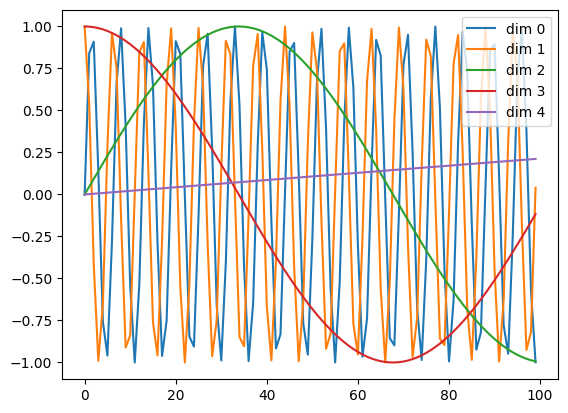

In [12]:
import matplotlib.pyplot as plt

emb_dim = 6

plt.figure()
x = list(range(100))
pos_vectors = [absolute_position_encoding(i, 6) for i in x]
for dim in range(5):
    y = [pv[dim].item() for pv in pos_vectors]
    plt.plot(x, y, label=f'dim {dim}')
plt.legend()
plt.show()

Apply the position encoding to the embeddings from earlier.

In [14]:
seq_len, emb_dim = embeddings.shape
pos_emb = torch.stack([absolute_position_encoding(i, emb_dim) for i in range(seq_len)], dim=0)
x = embeddings + pos_emb
x.shape

torch.Size([12, 6])

## Absolute Position Embedding
Write a class `AbsolutePositionEmbedding` that is initialized with a maximum length and an embedding dimension. In its `forward` method, it should take an input tensor (of shape `[batch_size, sequence_length, embedding_dim]`) and add the position embeddings to the input tensor.

In [21]:
class AbsolutePositionEmbedding(nn.Module):
    
    def __init__(self, embedding_dim, max_length=512):
        super().__init__()
        self.max_length = max_length
        self.pos_emb = nn.Embedding(max_length, embedding_dim)
    
    def forward(self, x):
        seq_len = x.size(1)
        assert seq_len <= self.max_length, "Input sequence too long"
        positions = torch.arange(seq_len)
        pos_emb = self.pos_emb(positions).unsqueeze(0)
        return x + pos_emb

Try your class with an example.

In [22]:
absolute_position_embedding = AbsolutePositionEmbedding(20, 512)
x1 = torch.randn(5, 12, 20)
x = absolute_position_embedding(x1)
print(x.shape)

torch.Size([5, 12, 20])


## Relative Position Embedding
Create a class `RelativePositionEmbedding` that is initialized with a maximum relative distance and an embedding dimension. Its `forward` method should take an input tensor of size `[batch_size, hidden_dim]` and apply the relative position embeddings given the positions $i$ of the query and $j$ of the key.

In [30]:
class RelativePositionEmbedding(nn.Module):
    
    def __init__(self, embedding_dim, max_dist=16):
        super().__init__()
        self.max_dist = max_dist
        self.rel_pos_emb = nn.Embedding(max_dist * 2 + 1, embedding_dim)
    
    def forward(self, x, i, j):
        rel_pos = j - i + self.max_dist
        rel_pos = max(0, min(2 * self.max_dist, rel_pos)) # Could use torch.clamp() if already tensor
        rel_pos_emb = self.rel_pos_emb(torch.tensor(rel_pos)).unsqueeze(0)
        return x + rel_pos_emb

Try it with an example.

In [31]:
rel_pos_emb = RelativePositionEmbedding(20, 16)
x = torch.randn(5, 20)
result = rel_pos_emb(x, 0, 3)
result = rel_pos_emb(x, 49, 15)
print(result.shape)

torch.Size([5, 20])


**Question:** Where would we use this module?

**Answer:** Self-attention

**Question:** Look at the HuggingFace implementation of relative position embeddings in the BERT model:
- [initialization from line 244](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/bert/modeling_bert.py#L244)
- [forward method from line 320](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/bert/modeling_bert.py#L320)

Describe what their `relative_key` method does differently from the [Shaw et al. (2018)](https://aclanthology.org/N18-2074/) paper we saw in the lecture.

**Answer:**